# Global Fishing Effort Trawlers

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
# from scipy import stats

In [3]:
import bq  
client = bq.Client.Get()

In [4]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer


In [37]:
# how many vessels?
q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE max_label_label = "Trawler" '''
neural_trawlers = int(Query(q)[0][0])

q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
     WHERE max_label_label = "Trawler"
     and max_label_score > .8'''
neural_trawlers_highconfidence = int(Query(q)[0][0])

q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
     WHERE max_label_label = "Trawler"
     and mmsi in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing])'''
neural_combined_trawlers = int(Query(q)[0][0])

q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
     WHERE max_label_label = "Trawler"
     and mmsi in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing])
     and max_label_score > .8'''
neural_combined_trawlers_highconfidence = int(Query(q)[0][0])


Waiting on bqjob_r4904bfd10da82419_000001548824ee7b_17 ... (0s) Current status: DONE   
Query time: 1.09290289879 seconds.
Waiting on bqjob_r648c54d5a000183c_000001548824f2c1_18 ... (0s) Current status: DONE   
Query time: 1.06357598305 seconds.
Waiting on bqjob_r3fe1d7b6c646c8f0_000001548824f6e9_19 ... (0s) Current status: DONE   
Query time: 0.919630050659 seconds.
Waiting on bqjob_r2a70e66973376330_000001548824fa82_20 ... (0s) Current status: DONE   
Query time: 2.20365595818 seconds.


In [38]:
print "Classified Trawlers:", neural_trawlers
print "Classified Trawlers High Confidence:", neural_trawlers_highconfidence
print "Classified Trawlers that are Likely Fishing Vessels:", neural_combined_trawlers
print "Classified Trawlers High Confidence that are Likely Fishing Vessels :", neural_combined_trawlers_highconfidence

Classified Trawlers: 17175
Classified Trawlers High Confidence: 13299
Classified Trawlers that are Likely Fishing Vessels: 12906
Classified Trawlers High Confidence that are Likely Fishing Vessels : 10714


In [26]:
q = '''
SELECT
  INTEGER(lat*2) lat_bin,
  INTEGER(lon*2) lon_bin,
  SUM(fishing_hours) fishing_hours
FROM (
  SELECT
    lat,
    lon,
    (last_hours + next_hours)/2 fishing_hours
  FROM
    [scratch_global_fishing_raster.2015_with_score_and_hours]
  WHERE
    measure_new_score > .5
    AND lat <90
    AND lon <180
    AND mmsi IN (
    SELECT
      INTEGER(mmsi)
    FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE
      max_label_label = "Trawler" )
    AND seg_id IN (
    SELECT
      seg_id,
    FROM
      [scratch_david_seg_analysis.2015_segments]
    WHERE
      NOT( point_count<=20
        OR (point_count<100
          AND point_count = terrestrial_positions)
        OR (min_lat >= 0
          AND max_lat <= 0.109225)
        OR (min_lon >= 0
          AND max_lon <= 0.109225) )))
GROUP BY
  lat_bin,
  lon_bin
'''

fishing_grid = Query(q)

Waiting on bqjob_r3d5ec50aa980e7ef_00000154881bc593_11 ... (23s) Current status: DONE   
Query time: 26.6248519421 seconds.


In [27]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

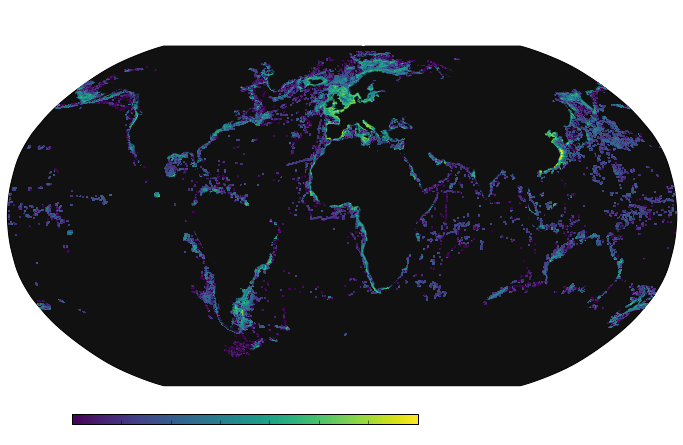

In [28]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours for Trawlers, 2015\nTralwers identified by the Neural Net"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_hours_trawlers_2015_v1.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [34]:
q = '''
SELECT
  INTEGER(lat*2) lat_bin,
  INTEGER(lon*2) lon_bin,
  SUM(fishing_hours) fishing_hours
FROM (
  SELECT
    lat,
    lon,
    (last_hours + next_hours)/2 fishing_hours
  FROM
    [scratch_global_fishing_raster.2015_with_score_and_hours]
  WHERE
    measure_new_score > .5
    AND lat <90
    AND lon <180
    AND mmsi IN (
    SELECT
      INTEGER(mmsi)
    FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE
      max_label_label = "Trawler" 
      and max_label_score > .8)
    AND seg_id IN (
    SELECT
      seg_id,
    FROM
      [scratch_david_seg_analysis.2015_segments]
    WHERE
      NOT( point_count<=20
        OR (point_count<100
          AND point_count = terrestrial_positions)
        OR (min_lat >= 0
          AND max_lat <= 0.109225)
        OR (min_lon >= 0
          AND max_lon <= 0.109225) )))
GROUP BY
  lat_bin,
  lon_bin
'''

fishing_grid = Query(q)

Waiting on bqjob_r105f9ef29f11af9b_00000154882390eb_16 ... (23s) Current status: DONE   
Query time: 27.2410979271 seconds.


In [35]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

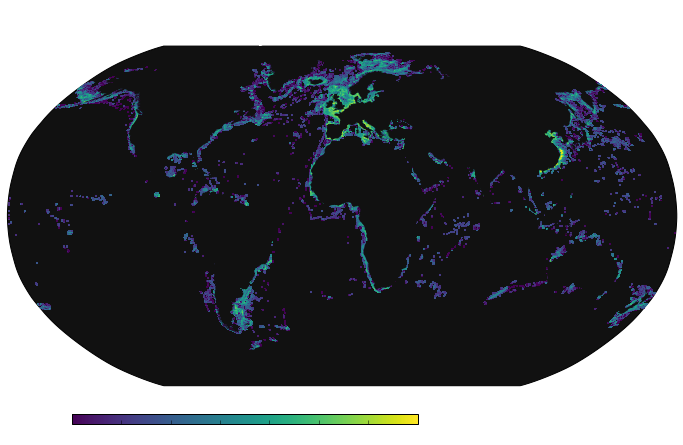

In [36]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours for Trawlers, 2015\nTralwers identified by the Neural Net with Confidence > 0.8"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_hours_trawlers_2015_highconfidence_v1.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [29]:
q = '''
SELECT
  INTEGER(lat*2) lat_bin,
  INTEGER(lon*2) lon_bin,
  SUM(fishing_hours) fishing_hours
FROM (
  SELECT
    lat,
    lon,
    (last_hours + next_hours)/2 fishing_hours
  FROM
    [scratch_global_fishing_raster.2015_with_score_and_hours]
  WHERE
    measure_new_score > .5
    and lat <90 
    and lon <180
    AND mmsi IN (
    SELECT
      integer(mmsi)
    FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE
      max_label_label = "Trawler"
    and mmsi in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing]))
    AND seg_id IN (
    SELECT
      seg_id,
    FROM
      [scratch_david_seg_analysis.2015_segments]
    WHERE
      NOT( point_count<=20
        OR (point_count<100
          AND point_count = terrestrial_positions)
        OR (min_lat >= 0
          AND max_lat <= 0.109225)
        OR (min_lon >= 0
          AND max_lon <= 0.109225) )))
GROUP BY
  lat_bin,
  lon_bin
'''

fishing_grid = Query(q)

Waiting on bqjob_r2a16decffdf6cef7_00000154881d2159_12 ... (0s) Current status: DONE   
Query time: 2.03217601776 seconds.


In [30]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

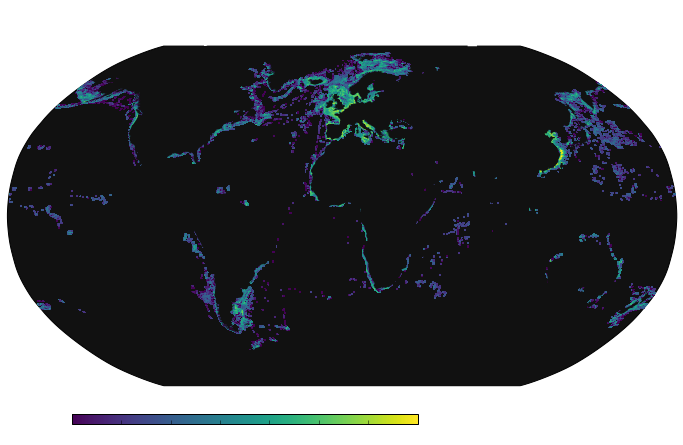

In [31]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours for Trawlers, 2015\nTralwers identified by the Neural Net also in 2015_combined_fishing list"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_hours_trawlers_2015_combinedfishing_v1.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [39]:
q = '''
SELECT
  INTEGER(lat*2) lat_bin,
  INTEGER(lon*2) lon_bin,
  SUM(fishing_hours) fishing_hours
FROM (
  SELECT
    lat,
    lon,
    (last_hours + next_hours)/2 fishing_hours
  FROM
    [scratch_global_fishing_raster.2015_with_score_and_hours]
  WHERE
    measure_new_score > .5
    and lat <90 
    and lon <180
    AND mmsi IN (
    SELECT
      integer(mmsi)
    FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE
      max_label_label = "Trawler"
      and max_label_score > .8
    and mmsi in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing]))
    AND seg_id IN (
    SELECT
      seg_id,
    FROM
      [scratch_david_seg_analysis.2015_segments]
    WHERE
      NOT( point_count<=20
        OR (point_count<100
          AND point_count = terrestrial_positions)
        OR (min_lat >= 0
          AND max_lat <= 0.109225)
        OR (min_lon >= 0
          AND max_lon <= 0.109225) )))
GROUP BY
  lat_bin,
  lon_bin
'''

fishing_grid = Query(q)

Waiting on bqjob_r380713c4afd0ea6e_0000015488286fa8_21 ... (23s) Current status: DONE   
Query time: 26.1605739594 seconds.


In [40]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

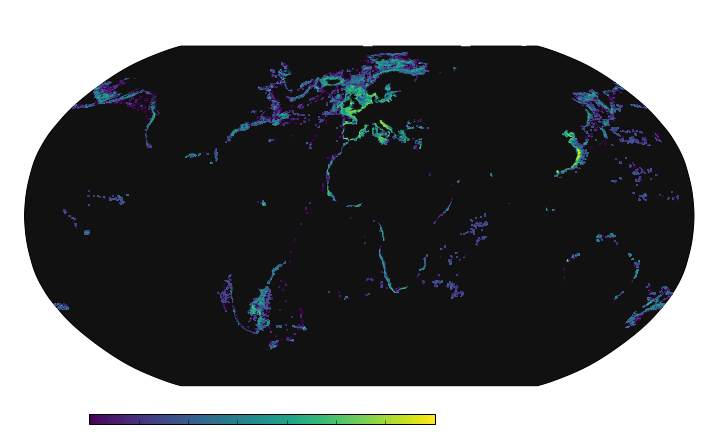

In [41]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours for Trawlers, 2015\nTralwers id'd by the Neural Net in 2015_combined_fishing w/ High Confidence"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_hours_trawlers_2015_combinedfishing_highcon_v1.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()